In [30]:
%matplotlib notebook
%matplotlib inline

from ipywidgets import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms

Consider following data generating scheme:
<p>
Parameters
<li> $N$ = sample size
<li> $p$ = probability of treatment
<li> $b$ = ATE (treatment effect)
</p>

<p>$Y_{pre}$ ~ Normal(1,1)</p>
<p>$A$ ~ Bernoulli(p)</p>
<p>$Y_{post}$ ~ Normal($b$*$A$ + $y_{pre}^2$, 1)

Run a simulation based on the following generated data as above and estimate the treatment effects using:
<li> Differences in means</li>
<li> Regression controlling for y_pre</li>
<li> CUPED controlling for y_pre</li>
<li> Difference in differences</li>

Repeat 10K times and assess bias and variance

## Coding CUPED

In [26]:
def cuped_adjustment(X, Y, assignment):
    cv = np.cov(X, Y)
    theta = cv[0,1] / cv[0,0]
    X_mu = np.mean(X)
    Y_cuped = Y - (X - X_mu)*theta
    return Y_cuped

# example implementation
# https://bytepawn.com/reducing-variance-in-ab-testing-with-cuped.html

In [27]:
def p_value(A,B):
    return stats.ttest_ind(A, B)

## What happens to bias and variance when assignment is correlated with pre-treatment data?

In [6]:
def generate_binomial(p):
    if p < 0.5:
        return 1
    else:
        return 0

In [8]:
data = [20, 50, 100, 200, 500, 600, 700, 800, 900, 1000]
p_array = [] 
b_array = [0, 50, 100]

alpha = 0.05 #power = 1-alpha

In [160]:
# This takes a bit to run since we are running the 10*2*3*10000 times
df = []
for i in data:
    for b in b_array:
        for sim in range (0, 10000):
            Y_pre = np.random.normal(1, 1, i)
            p = 1/(1+np.exp(1-Y_pre))
            A = np.array([generate_binomial(i) for i in p])
#                 A = np.random.binomial(1, p, i)
            Y_post = A*b  + np.square(Y_pre) + np.random.normal(0,1)

            simulation = pd.DataFrame({'Y_pre':Y_pre, 'Treatment':A, 'Y_post':Y_post})

            treatment = simulation[simulation['Treatment'] == 1]
            control = simulation[simulation['Treatment'] == 0]

    #         Difference in means
            t_mu = treatment['Y_post'].mean()
            c_mu = control['Y_post'].mean()
            mu_diff = t_mu - c_mu
            mean_diff_cm = sms.CompareMeans(sms.DescrStatsW(treatment['Y_post'].values), 
                                            sms.DescrStatsW(control['Y_post'].values))
            mean_diff_conf = mean_diff_cm.tconfint_diff(usevar='unequal')
            diff_means = {'method': 'diff_in_means',
                               'N': i,
                               'observed_treatment_effect':mu_diff,
                               'conf_int':mean_diff_conf,
                         'sim_num': sim,
                         'b': b}

            X = simulation.iloc[:, :2].values
            Y = simulation['Y_post'].values

            model_lr = sm.OLS(Y, sm.add_constant(X)).fit()
            conf_interval = model_lr.conf_int(alpha)
            b_conf_int = conf_interval[-1]


            #check that coef of our treatment effect, should return  b
            regression_data = {'method': 'regression',
                               'N': i,
                               'observed_treatment_effect':model_lr.params[-1],
                               'conf_int':tuple(b_conf_int),
                         'sim_num': sim,
                         'b': b}


    # #         Diff-in-diff implementation
    #         t_pre_mu = treatment['Y_post'].mean()
    #         c_pre_mu = control['Y_post'].mean()
    #         t_did = t_mu - t_pre_mu
    #         c_did = c_mu - c_pre_mu
    #         did = c_did - t_did

    #         simulation['XA'] = simulation['Treatment']*simulation['Y_pre']
    #         model_did = LinearRegression()
    #         X_did = simulation[['Y_pre', 'Treatment', 'XA']]
    #         Y_did = simulation.Y_post
    # #         X_did = sm.add_constant(X_did)
    #         model_did = sm.OLS(Y_did,X_did).fit()
    #         model_did.coef
    #         conf_interval_did = model_did.conf_int(alpha)
    #         did_conf_int = conf_interval_did[-1]
    #         did_data = {'method': 'did',
    #                    'N': i,
    #                    'observed_treatment_effect':did,
    #                    'conf_int':tuple(did_conf_int),
    #                   'sim_num': sim}    


        #     print("CUPED Adjusted Mean")
            Y_cuped = cuped_adjustment(X[:, 0],Y,A)
        #     X is covariates, Y is outcome, A = assignment
            Y_t_cuped = Y_cuped[np.where(A==1)]
            Y_c_cuped = Y_cuped[np.where(A==0)]

            t_cuped_mu = np.mean(Y_t_cuped)
            c_cuped_mu = np.mean(Y_c_cuped)
            diff_cuped = t_cuped_mu - c_cuped_mu
            cm = sms.CompareMeans(sms.DescrStatsW(Y_t_cuped), sms.DescrStatsW(Y_c_cuped))
            cuped_conf = cm.tconfint_diff(usevar='unequal')
        #     print(cm.tconfint_diff(usevar='unequal'))
        #     pval = p_value(Y_t_cuped, Y_c_cuped)
        #     print(diff_cuped)
        #     print(pval)
        #     print(cm)
        #     print()
        #     build dataframe
            cuped_data = {'method': 'cuped',
                          'N': i,
                          'observed_treatment_effect':diff_cuped,
                          'conf_int':cuped_conf,
                         'sim_num': sim,
                         'b': b}

            df.append(diff_means)
            df.append(regression_data)
            df.append(cuped_data)

C:\Users\shuan\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
C:\Users\shuan\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:188: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / self.sum_weights
C:\Users\shuan\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5739: RuntimeWarning: invalid value encountered in greater
  return df > 0
C:\Users\shuan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shuan\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\shuan\anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:823: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(d1._var / (d1.nobs-1) + d2

In [18]:
mydata = pd.read_csv('data_simulation2.csv', index_col=0)

In [ ]:
# mydata = pd.DataFrame.from_dict(df)

## Inspect/clean data

In [28]:
mydata.head()

,method,N,observed_treatment_effect,conf_int,sim_num,b,conf_low,conf_high,conf_width
0,diff_in_means,20,-3.902338,"(-6.374286771059764, -1.4303897319885914)",0,0,-6.374287,-1.430390,4.943897
1,regression,20,-0.973890,"(-3.628695690304257, 1.6809156851565756)",0,0,-3.628696,1.680916,5.309611
2,cuped,20,-0.402681,"(-2.0684946507553845, 1.2631320605493097)",0,0,-2.068495,1.263132,3.331627
3,diff_in_means,20,-2.325502,"(-3.0538342921107606, -1.597169809245763)",1,0,-3.053834,-1.597170,1.456664
4,regression,20,-0.798390,"(-1.8338591249303011, 0.23707902486665844)",1,0,-1.833859,0.237079,2.070938


In [20]:
## this block only need to be run if you are cleaning the data after the data generation for the first time
# mydata['conf_low'] = mydata['conf_int'].apply(lambda x: tuple(x)[0])
# mydata['conf_high'] = mydata['conf_int'].apply(lambda x: tuple(x)[1])
# mydata['conf_width'] = mydata['conf_high'] - mydata['conf_low'] 

# #write data to csv
# # mydata.to_csv('data_simulation2.csv')

## Plot Bias and Variance

# Bias

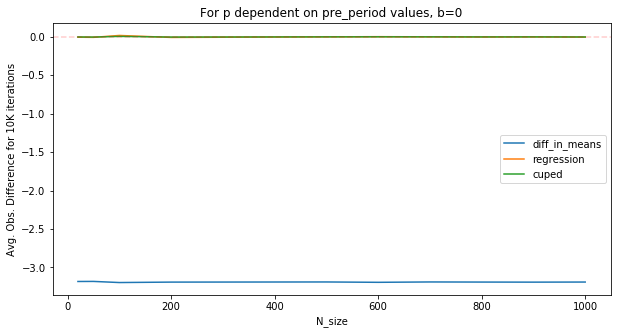

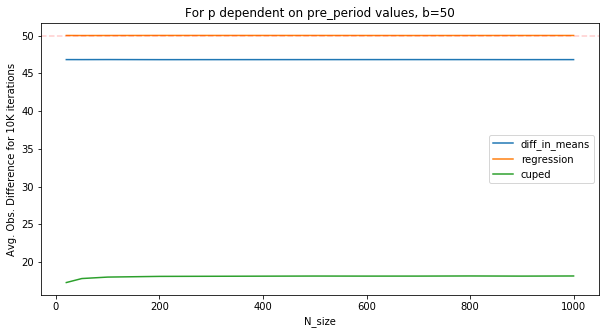

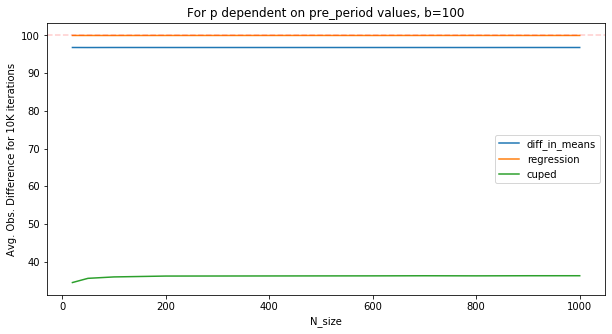

In [31]:
for b in b_array:
    labels = []
    x_array = []
    y_array = []
    fig, ax = plt.subplots(figsize=(10,5))
    
    for m in mydata['method'].unique():
    #     for plot of variance we're going to get the std dev of each of the 10000 simulations for each methodology
        x = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean().reset_index().N
        y = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean()['observed_treatment_effect'].values
        y_array.append(y)
        x_array.append(x)
        labels.append(m)
        #     ci_low = mydata[mydata['method'] == m]['conf_low'].values
        #     ci_high = mydata[mydata['method'] == m]['conf_high'].values
    for i in range(len(y_array)):
        ax.plot(x_array[i], y_array[i], label=labels[i])
    ax.legend()
    plt.axhline(y=b, color='r', linestyle='--', alpha = 0.2)
    ax.set_title("For p dependent on pre_period values, b={}".format(b))
    ax.set_xlabel('N_size')
    ax.set_ylabel('Avg. Obs. Difference for 10K iterations')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

# Variance

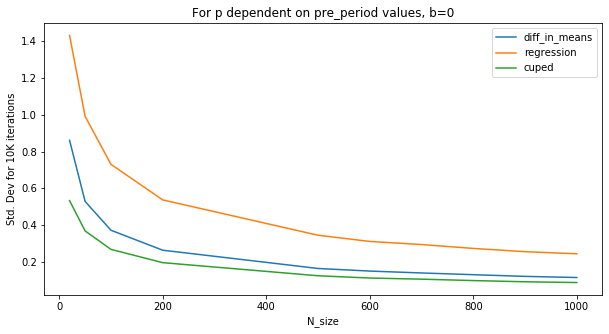

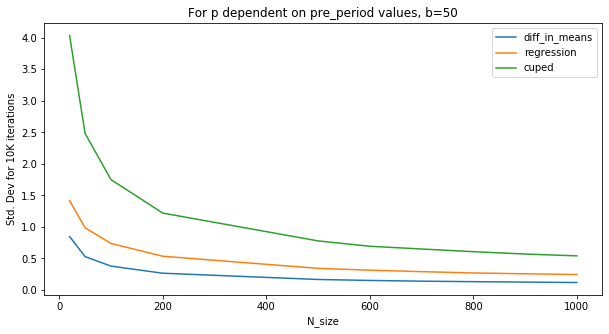

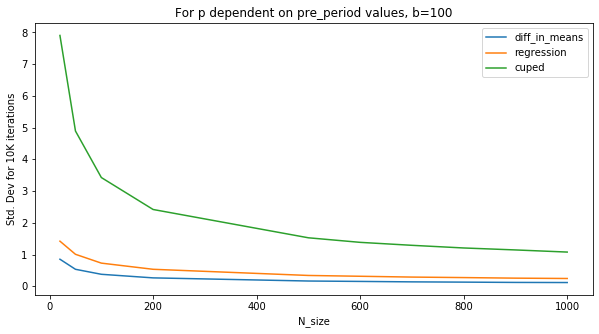

In [163]:
for b in b_array:
    labels = []
    x_array = []
    y_array = []
    fig, ax = plt.subplots(figsize=(10,5))
    
    for m in mydata['method'].unique():
    #     for plot of variance we're going to get the std dev of each of the 10000 simulations for each methodology
        x = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean().reset_index().N
        y = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').agg('std')['observed_treatment_effect'].values
        y_array.append(y)
        x_array.append(x)
        labels.append(m)
        #     ci_low = mydata[mydata['method'] == m]['conf_low'].values
        #     ci_high = mydata[mydata['method'] == m]['conf_high'].values
    for i in range(len(y_array)):
        ax.plot(x_array[i], y_array[i], label=labels[i])
    ax.legend()
    ax.set_title("For p dependent on pre_period values, b={}".format(b))
    ax.set_xlabel('N_size')
    ax.set_ylabel('Std. Dev for 10K iterations')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

## Make an interactive plot to compare the parameters

In [45]:
def interactive_bias_plot(b):
    labels = []
    x_array = []
    y_array = []
    fig, ax = plt.subplots(figsize=(10,5))
    
    for m in mydata['method'].unique():
    #     for plot of variance we're going to get the std dev of each of the 10000 simulations for each methodology
        x = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean().reset_index().N
        y = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean()['observed_treatment_effect'].values
        y_array.append(y)
        x_array.append(x)
        labels.append(m)
        #     ci_low = mydata[mydata['method'] == m]['conf_low'].values
        #     ci_high = mydata[mydata['method'] == m]['conf_high'].values
        
    for i in range(len(y_array)):
        ax.plot(x_array[i], y_array[i], label=labels[i])
    ax.legend()
    plt.axhline(y=b, color='r', linestyle='--', alpha = 0.2)

    #     ax.fill_between(x, (ci_low), (ci_high), color='b', alpha=.1)
    ax.set_title("Bias: For p dependent on pre_period values, b={}".format(b))
    ax.set_xlabel('N_size')
    ax.set_ylabel('Avg. Obs. Difference for 10K iterations')
    fig.show()



In [47]:
def interactive_std_plot(b):
    labels = []
    x_array = []
    y_array = []
    fig, ax = plt.subplots(figsize=(10,5))
    
    for m in mydata['method'].unique():
    #     for plot of variance we're going to get the std dev of each of the 10000 simulations for each methodology
        x = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').mean().reset_index().N
        y = mydata[(mydata['method'] == m) & (mydata.b == b)].groupby('N').agg('std')['observed_treatment_effect'].values
        y_array.append(y)
        x_array.append(x)
        labels.append(m)
        #     ci_low = mydata[mydata['method'] == m]['conf_low'].values
        #     ci_high = mydata[mydata['method'] == m]['conf_high'].values
    for i in range(len(y_array)):
        ax.plot(x_array[i], y_array[i], label=labels[i])
    ax.legend()
    ax.set_title("Variance: For p dependent on pre_period values, b={}".format(b))
    ax.set_xlabel('N_size')
    ax.set_ylabel('Std. Dev for 10K iterations')


# mydata[mydata['method'] == 'diff_in_means'].plot(x = 'N', y = 'observed_treatment_effect')

In [48]:
interact(interactive_std_plot, b=(0, 100, 50))

interactive(children=(IntSlider(value=50, description='b', step=50), Output()), _dom_classes=('widget-interact…

<function __main__.interactive_std_plot(b)>